# *Importing Necessary Libraries*

We will be using :
1. **Regex (re)** to extract and manipulate strings based on specific patterns.
    - References:
        - [Regex - Python Docs](https://docs.python.org/3/library/re.html)
        - [Regex cheatsheet](https://www.rexegg.com/regex-quickstart.html)
        - [Regex Test - live](https://regexr.com/)
        - [Datetime Format](http://strftime.org/)
2. **pandas** for analysis.
3. **matlotlib** and **seaborn** for visualization.
4. **emoji** to deal with emojis.
    - References:
        - [Python Docs](https://pypi.org/project/emoji/)
        - [Emoji](https://github.com/carpedm20/emoji)
        - [EMOJI CHEAT SHEET](https://www.webfx.com/tools/emoji-cheat-sheet/)
5. **wordcloud** for the most used words.

In [2]:
!pip install wordcloud



   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   ----- --------------------------------- 41.0/300.2 kB 653.6 kB/s eta 0:00:01
   ------------ --------------------------- 92.2/300.2 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 300.2/300.2 kB 2.3 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.3.2 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install emoji

   ---------------------------------------- 0.0/431.4 kB ? eta -:--:--
    --------------------------------------- 10.2/431.4 kB ? eta -:--:--
   --- ----------------------------------- 41.0/431.4 kB 495.5 kB/s eta 0:00:01
   --------------- ------------------------ 163.8/431.4 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 431.4/431.4 kB 3.0 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.3.2 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
!pip install itertools
!pip install collections
!pip install warnings

ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools

[notice] A new release of pip is available: 23.3.2 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections

[notice] A new release of pip is available: 23.3.2 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement warnings (from versions: none)
ERROR: No matching distribution found for warnings

[notice] A new release of pip is available: 23.3.2 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
import itertools 
from collections import Counter
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

##### NOTE: 
- This special command `%matplotlib inline` to ensure that plots are shown and embedded within the Jupyter notebook itself. Without this command, sometimes plots may show up in pop-up windows.
- `warnings.filterwarnings('ignore')`: The warnings filter controls whether warnings are ignored, displayed, or turned into errors (raising an exception). [REFERENCE](https://docs.python.org/3/library/warnings.html)

## *Preparation and reading data*

In [61]:
import pandas as pd
import re

def rawToDf(file, key):
    '''Converts raw .txt file into a Data Frame'''
    
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%m/%d/%y, %I:%M %p - ',
        '24hr' : '%m/%d/%y, %H:%M - ',
        'custom': ''
    }
    
    with open(file, 'r', encoding='utf-8') as raw_data:
        raw_string = ' '.join(raw_data.read().split('\n')) # Joining lines into a single string
        user_msg = re.split(split_formats[key], raw_string)[1:] # Splitting based on datetime pattern
        date_time = re.findall(split_formats[key], raw_string) # Extracting datetime patterns
        
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg})
        
    # Convert date_time column to datetime format
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key], errors='coerce')
    
    # Split user and message
    usernames = []
    msgs = []
    for msg in df['user_msg']:
        try:
            parts = re.split('([\w\W]+?):\s', msg)
            if len(parts) > 1:
                usernames.append(parts[1])
                msgs.append(parts[2])
            else:
                usernames.append("group_notification")
                msgs.append(parts[0])
        except IndexError:
            usernames.append("group_notification")
            msgs.append(msg)

    df['user'] = usernames
    df['message'] = msgs
    
    df.drop('user_msg', axis=1, inplace=True)
    
    return df

# Example usage:
df = rawToDf('WhatsApp Chat with Aditya Chaudhary.txt', '12hr')
print(df.head())


            date_time                user  \
0 2023-03-27 10:36:00  group_notification   
1 2023-05-21 07:07:00        Nimish Gupta   
2 2023-05-21 07:26:00    Aditya Chaudhary   
3 2023-09-26 18:06:00    Aditya Chaudhary   
4 2023-09-26 18:07:00    Aditya Chaudhary   

                                             message  
0  Messages and calls are end-to-end encrypted. N...  
1                        Happy birthday bhaii🎉🎉🎂🎂🍻🍻   
2                            Thanku so much bhaii🫶🫶   
3                                              Bhai   
4             Kasol side abhi thoda Mausam kharab h   


#### *NOTE*:
- Since WhatsApp texts are *multi-line*, you cannot just read the file line by line and get each message that you want. Instead, you need a way to *identify* if a line is a new message or part of an old message. You could use regular expressions.
- While reading each line, I split it based on a comma and take the first item returned from the `split()` function. If the line is a new message, the first item would be a valid date, and it will be appended as a new message to the list of messages. If it’s not, the message is part of the previous message, and hence, will be appended to the end of the previous message as one continuous message.

In [60]:
df = rawToDf('WhatsApp Chat with Aditya Chaudhary.txt', '12hr')

ValueError: time data "3/27/23, 10:36 AM - " doesn't match format "%d/%m/%Y, %I:%M %p - ", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

## *Prior Information of my Whatsapp Data*
- This is my most active college coding group.
- It has **235+** participants; 237 to be precise.
- This group was made in **January 2020.**

## Pre-Processing

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1071 entries, 0 to 1070
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  1071 non-null   datetime64[ns]
 1   user       1071 non-null   object        
 2   message    1071 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 25.2+ KB


### The dataset contains 3 rows, and 13655 respective entries.
- Here is how it looks like:

In [63]:
df.sample(10)

,date_time,user,message
293,2024-01-04 17:38:00,Aditya Chaudhary,To koi dekh skte h
613,2024-03-11 10:32:00,Aditya Chaudhary,12 baje aunga
156,2023-12-03 19:11:00,Aditya Chaudhary,Lag to ni rha kuch krengi
708,2024-03-21 09:28:00,Nimish Gupta,Sab ho jaega
267,2024-01-03 11:48:00,Aditya Chaudhary,Btata hu pkka se abhi...
483,2024-02-16 14:46:00,Aditya Chaudhary,Topic Google krke
955,2024-06-25 21:39:00,Aditya Chaudhary,Bta kya plan rakhna
130,2023-11-12 12:13:00,Nimish Gupta,happy Diwali bhaiiii🥰🙏
750,2024-03-21 09:35:00,Aditya Chaudhary,Enjoy kro!!
479,2024-02-16 14:44:00,Nimish Gupta,aur cnn bhai sir ki ppt main toh clear sa nahi...


### An important observation
- One might wonder there are no NaNs, but as you can see, there are some rows, where messages are an *empty string.*
- This can be because, the message might just contain **emojis.**
#### To see, how many such rows are there, we can use `df[df['message'] == ""].shape[0]`

In [64]:
df[df['message'] == ""].shape[0]

5

## Adding extra *helper columns for analysis and visualization*

In [65]:
df['day'] = df['date_time'].dt.strftime('%a')
df['month'] = df['date_time'].dt.strftime('%b')
df['year'] = df['date_time'].dt.year
df['date'] = df['date_time'].apply(lambda x: x.date())

# Now that we have a clean DataFrame to work with, it’s time to perform analysis on it.
### Final Data Frame

In [66]:
df

,date_time,user,message,day,month,year,date
0,2023-03-27 10:36:00,group_notification,Messages and calls are end-to-end encrypted. N...,Mon,Mar,2023,2023-03-27
1,2023-05-21 07:07:00,Nimish Gupta,Happy birthday bhaii🎉🎉🎂🎂🍻🍻,Sun,May,2023,2023-05-21
2,2023-05-21 07:26:00,Aditya Chaudhary,Thanku so much bhaii🫶🫶,Sun,May,2023,2023-05-21
3,2023-09-26 18:06:00,Aditya Chaudhary,Bhai,Tue,Sep,2023,2023-09-26
4,2023-09-26 18:07:00,Aditya Chaudhary,Kasol side abhi thoda Mausam kharab h,Tue,Sep,2023,2023-09-26
...,...,...,...,...,...,...,...
1066,2024-07-01 18:34:00,Nimish Gupta,Kisi ka hua?,Mon,Jul,2024,2024-07-01
1067,2024-07-01 18:37:00,Aditya Chaudhary,Achaa,Mon,Jul,2024,2024-07-01
1068,2024-07-01 18:37:00,Aditya Chaudhary,No idea,Mon,Jul,2024,2024-07-01
1069,2024-07-01 18:37:00,Aditya Chaudhary,Tera pta tha tune diya,Mon,Jul,2024,2024-07-01


# *Data Analysis*

**1. Overall frequency of total messages on the group.**

**2. Top 10 most active days.**

**3. Top 10 active users on the group (with a twist).**
- Ghosts present in the group. (shocking results.)

**4. Top 10 users most sent media.**

**5. Top 10 most used emojis.**

**6. Most active hours and days.**
 - Heatmaps of weekdays and months.
 - Most active hours, weekdays, and months.

**7. Most used words - WordCloud**

# 1. Overall frequency of total messages on the group.
- I will first do this to get a look at overall data.

I will plot a simple line graph to see the frequency of messages over the months.
##### I expect to see a nice line graph with crests and troughs in odd places.

In [68]:
df1 = df.copy()  # Use a copy of the original dataframe to avoid loss of data
df1['message_count'] = 1  # Adding an extra helper column
df1.drop(columns='year', inplace=True)  # Dropping unnecessary columns

# Select only the numeric columns for the summation
numeric_columns = df1.select_dtypes(include='number').columns
df1 = df1.groupby('date')[numeric_columns].sum().reset_index()  # Group by date and sum numeric columns

print(df1)


          date  message_count
0   2023-03-27              1
1   2023-05-21              2
2   2023-09-26             60
3   2023-11-06              2
4   2023-11-07             63
..         ...            ...
73  2024-06-25             42
74  2024-06-26             34
75  2024-06-27              3
76  2024-06-29             14
77  2024-07-01             26

[78 rows x 2 columns]


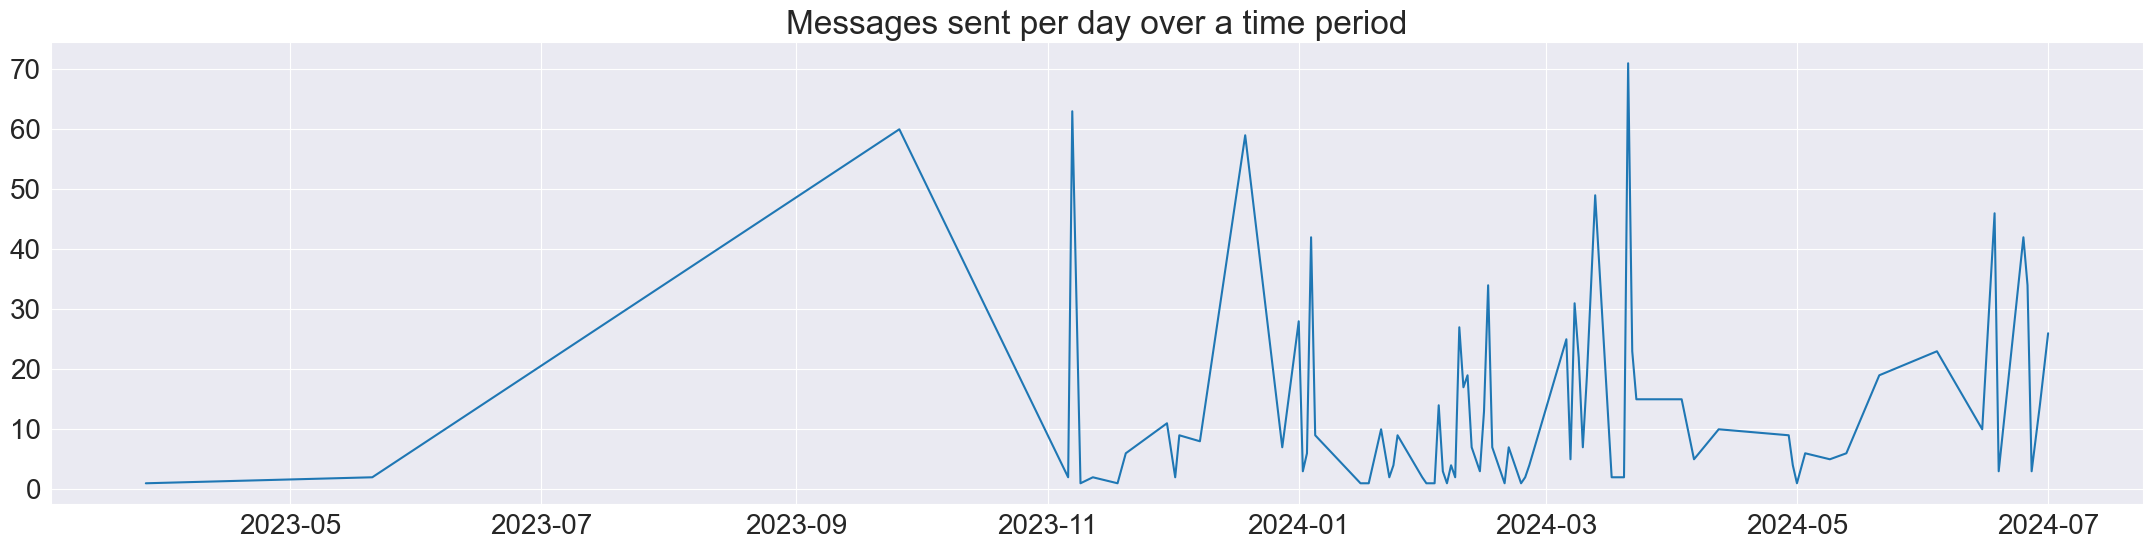

In [69]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (27, 6)      # Same as `plt.figure(figsize = (27, 6))`


# A basic plot
plt.plot(df1.date, df1.message_count)
plt.title('Messages sent per day over a time period');

# Could have used Seaborn's lineplot as well.
# sns.lineplot(df1.date, df1.message_count);   


# Saving the plots
plt.savefig('msg_plots.svg', format = 'svg')

# 2 *Top 10 most active days.*

In [70]:
top10days = df1.sort_values(by="message_count", ascending=False).head(10)    # Sort values according to the number of messages per day.
top10days.reset_index(inplace=True)           # reset index in order.
top10days.drop(columns="index", inplace=True) # dropping original indices.
top10days

,date,message_count
0,2024-03-21,71
1,2023-11-07,63
2,2023-09-26,60
3,2023-12-19,59
4,2024-03-13,49
5,2024-06-18,46
6,2024-06-25,42
7,2024-01-04,42
8,2024-02-16,34
9,2024-06-26,34


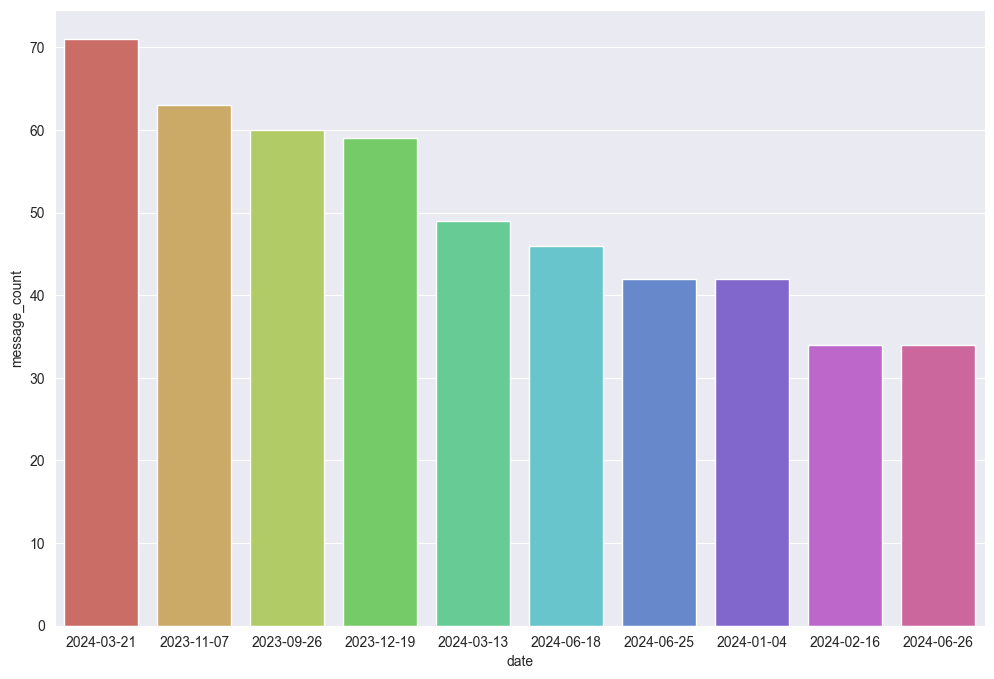

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readability;
import matplotlib
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (12, 8)

# A bar plot for top 10 days
sns.barplot(x='date', y='message_count', data=top10days, palette="hls")

# Saving the plot
plt.savefig('top10_days.svg', format='svg')

# Show plot
plt.show()


#### Apparently, the group was very active on 13th Spetember'20
- Because we were discussing fundamental yet tricky and brain-wracking "Guess the Output" Java questions!

# 3. Top 10 active users on the group.

### Before, analysing that, we will see the *number of Ghosts* in the group.

In [72]:
# Total number of people who have sent at least one message on the group;
print(f"Total number of people who have sent at least one message on the group are {len(df.user.unique()) - 1}")   # `-1` because excluding "group_notficiation"

print(f"Number of people who haven't sent even a single message on the group are {237 - len(df.user.unique()) - 1}")

Total number of people who have sent at least one message on the group are 2
Number of people who haven't sent even a single message on the group are 233


### *Shocking Result*
- Total number of people who have sent at least one message on the group are **154**.
- BUT, the total number of participants were **237**.
- **That means 81 people in the group have not sent even a single message throughout these 9 months and 13500+ messages.**

## Now, pre-processing top 10 active users.

In [73]:
df2 = df.copy()    
df2 = df2[df2.user != "group_notification"]
top10df = df2.groupby("user")["message"].count().sort_values(ascending=False)

# Final Data Frame
top10df = top10df.head(10).reset_index()
top10df

,user,message
0,Nimish Gupta,571
1,Aditya Chaudhary,499


## Now, visualizing top 10 active users.
### *Replacing names with initials for better visualization*

In [74]:
top10df['initials'] = ''
for i in range(10):
    top10df.initials[i] = top10df.user[i].split()[0][0] + top10df.user[i].split()[1][0]
    
top10df.initials[7] = "Me"    # That's me
top10df.initials[8] = "DT"

KeyError: 2

### Starting with a basic plot.
- [Color References for Matplotlib](https://matplotlib.org/3.1.0/gallery/color/named_colors.html)

- **Improving Default Styles using Seaborn**

    - [References](https://seaborn.pydata.org/generated/seaborn.set_style.html)

In [75]:
# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

## *Now, I will be trying different visualization methods.*

##### Plotting a simple line graph.

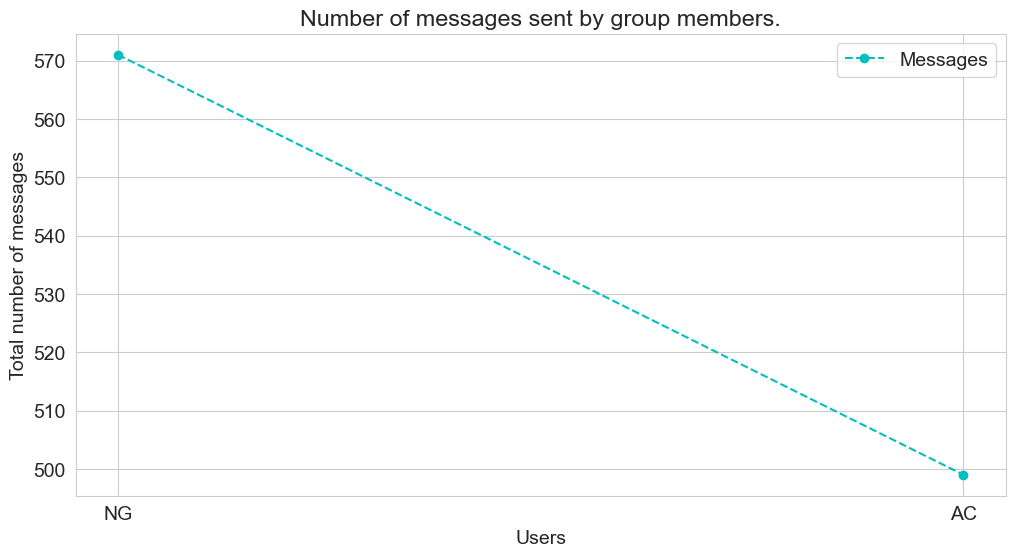

In [76]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12, 6))


# plt.plot(top10df.initials, top10df.message, marker='o', ls='--', c='cyan')

# BETTER IMPLEMENTATION using the `fmt` argument;
plt.plot(top10df.initials, top10df.message, 'o--c')  


# Labels and Title 
plt.xlabel('Users')
plt.ylabel('Total number of messages')

plt.title("Number of messages sent by group members.")
plt.legend(['Messages']);

# Saving the plots
# plt.savefig('msg_plots.svg', format = 'svg')

#### *Plotting a bar chart and line graph together.*

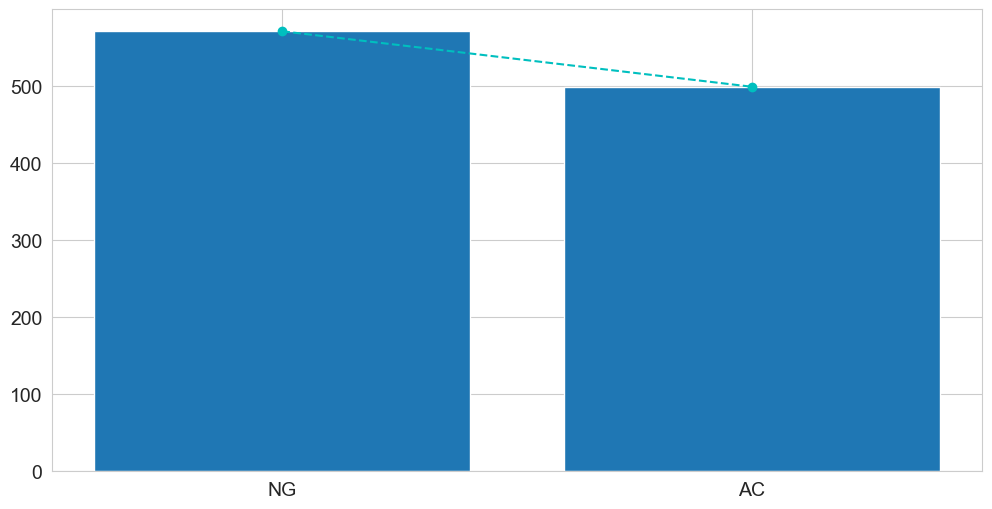

In [77]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12, 6))

plt.bar(top10df.initials, top10df.message)   # basic bar chart
plt.plot(top10df.initials, top10df.message, 'o--c');   # line chart

### *Beautifying Default Styles using Seaborn*

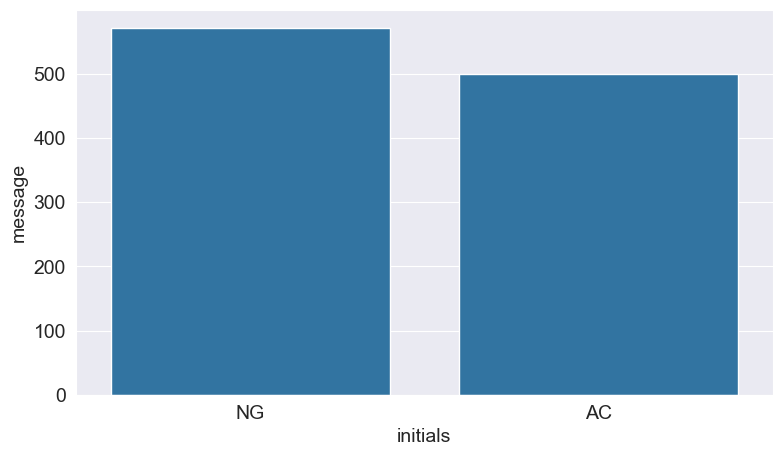

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Creating the bar plot
sns.barplot(x='initials', y='message', data=top10df)

# Display the plot
plt.show()


# *Important Note*

- Since almost all the plots will be ***comparing* one person with another**, I’ll assign a **specific colour to each person** so that it becomes **easy to identify** each person among *multiple plots*. 

- I could've used *seaborn's color palette* but:
    - Seaborn assigns default colors itself, but i wanted the color of a **certain person remains the same, no matter the plot**;
    - Also, I wanted to try some different colors so I grabbed my **colour palette** from https://coolors.co/

- Next, I made a dictionary where each key is the name and the value for each would be their assigned colour. I create a function which reorders colours given a list of names to match the ordering of the plot. This function takes the ordered names as input and returns a reordered list of colours. This list has to be passed into the `pallete` argument in a seaborn plotting function.

## Defining a function to tackle the problem.

I'm defining the following function to ***maintain consistent colors for each person across all plots***. Since the order will vary depending on the plot, this is passed to the function which will reorder colors in a particular order so that **the color of a certain person remains the same no matter the plot**. This will help maintain **consistency and readability** amongst the many graphs I will be plotting.


In [79]:
def get_colors_of_certain_order(names_in_certain_order):
    '''the color of a certain person remains the same, no matter the plot'''
    
    order = list(names_in_certain_order)
    return_list = []
    
    for name in order:
        return_list.append(color_dict[name])
        
    return return_list

### Now, we have a really nice set of colours for each person, with which we can visualize using `sns.palplot`.

{'NG': '#F94144', 'AC': '#F3722C'}

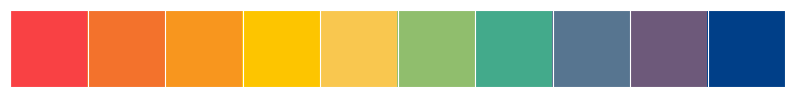

In [80]:
colors = ['#F94144', '#F3722C', '#F8961E', '#FDC500', '#F9C74F', '#90BE6D', '#43AA8B', '#577590', '#6D597A','#003F88']
sns.palplot(colors)    # visualizing the colors' list

names = top10df.initials

color_dict = {}
for name, color in zip(names, colors):
    color_dict[name] = color
color_dict

## Now, finding the *average message length* of the 10 most active users of the group.

In [81]:
import pandas as pd

# Adding another column for message length using the apply method
df2['message_length'] = df2['message'].apply(lambda x: len(x))

# Creating another dataframe for average length per user
avg_msg_lengths = df2.groupby('user', as_index=False)['message_length'].mean().sort_values(by='message_length', ascending=False)

# Creating helper columns
top10df['avg_message_length'] = 0

# Updating the average message length for the top 10 users
for i, user in enumerate(top10df['user']):
    avg_length = avg_msg_lengths[avg_msg_lengths['user'] == user]['message_length']
    if not avg_length.empty:
        top10df.at[i, 'avg_message_length'] = avg_length.values[0]

# Sorting the average message lengths of the same to 10 active users
top10df_msg = top10df.sort_values(by="avg_message_length", ascending=False)

# Display the result
top10df_msg


,user,message,initials,avg_message_length
1,Aditya Chaudhary,499,AC,18.807615
0,Nimish Gupta,571,NG,16.654991


## Now, we will be plotting *most sent messages* and respective *average message lengths* simultaneously, to see some interesting results.
- Plotting multiple charts in a grid
    - Matplotlib and Seaborn also support plotting multiple charts in a grid, using `plt.subplots`, which returns a set of axes that can be used for plotting.

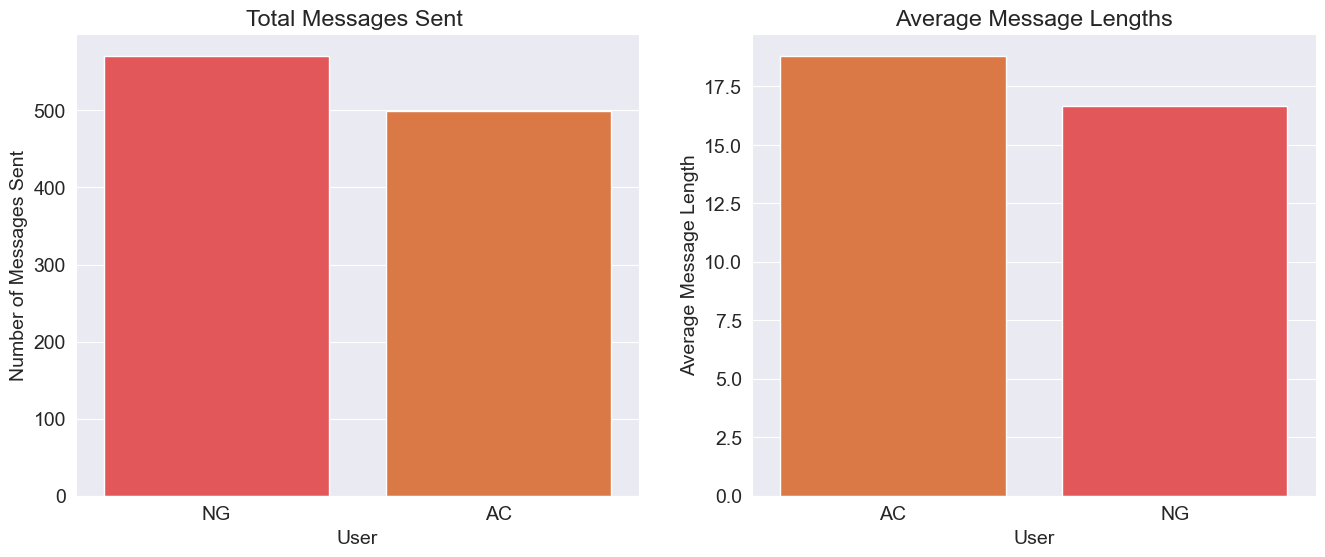

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming get_colors_of_certain_order function is defined elsewhere
# from some_module import get_colors_of_certain_order

# plotting multiple charts in a grid
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set_style("darkgrid")

# Plot 1 - Countplot of total messages sent
sns.barplot(x='initials', y='message', data=top10df, ax=axes[0], palette=get_colors_of_certain_order(top10df.initials))     # Note: the palette argument;

axes[0].set_title('Total Messages Sent ')
axes[0].set_xlabel('User')
axes[0].set_ylabel('Number of Messages Sent')

# Plot 2 - Barplot of those top 10 users' average message lengths
sns.barplot(x='initials', y='avg_message_length', data=top10df_msg, ax=axes[1], palette=get_colors_of_certain_order(top10df_msg.initials))    # Note: the respective palette argument;

axes[1].set_title('Average Message Lengths')
axes[1].set_xlabel('User')
axes[1].set_ylabel('Average Message Length')

# Saving the plots
plt.savefig('top10_msg_plots_diff.svg', format='svg')
plt.show()


### It’s really interesting to see plots like this *side by side*, because here comes the twist:

- Ironically, **TK**, the person who sent the **most amount of texts** (2000+), has ***least*** messages' length on *average*. This means this person sends broken and many WhatsApp messages in one go. 

- We can see that, **I** send less number of messages while having a **relatively longer message length**, followed by **KS**.

- Here's a **snippet** of how TK sends messages:

<img src="https://imgur.com/xznZczG.png">

#### "*Things aren't always the way they seem like.*"

# 4. Top 10 users most sent media 

- The exported chats were exported without any media files. Any message that contained media was indicated with `‘<Media Omitted> ’`. 

### *Pre-processing*
**We can use this to filter out and see who sends the most media.**

In [83]:
# Using `groupby`, `count` and `sort_values` attributes.
top10media = df[df.message == '<Media omitted> '].groupby('user').count().sort_values(by="message", ascending = False).head(10)

# Dropping unused column;
top10media.drop(columns=['date_time', 'day', 'month', 'year', 'date'], inplace=True)

# Renaming column name for visualization;
top10media.rename(columns={"message": "media_sent"}, inplace=True)

# resetting index;
top10media.reset_index(inplace=True)

top10media['initials'] = ''
for i in range(10):
    top10media.initials[i] = top10media.user[i].split()[0][0] + top10media.user[i].split()[1][0]

top10media.initials[2] = "Me"    # That's me
top10media.initials[9] = "VR"

KeyError: 2

### *Visualization using different Seaborn's Color Palettes*
- [Seaborn References](http://seaborn.pydata.org/tutorial/color_palettes.html#using-circular-color-systems)
- [Seaborn's Different Colors](https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08)
- [Seaborn's Color Visualization](https://python-graph-gallery.com/197-available-color-palettes-with-matplotlib/)

###### QUICK HACK
- to get **all possible Seaborn's color palettes**:
    - Just put a random input `palette="xyz"`
    - It will then show an error, showing all possible palettes you can try out from!

### Which user sends the most media?

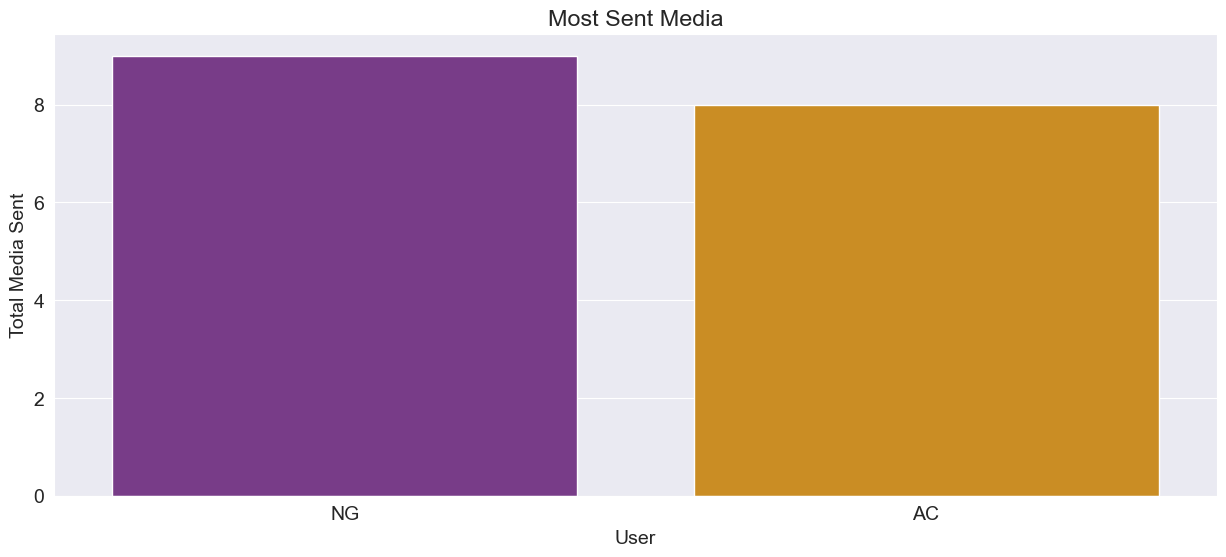

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Increasing the figure size
plt.figure(figsize=(15, 6))

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting a bar graph
sns.barplot(x='initials', y='media_sent', data=top10media, palette="CMRmap")

plt.title('Most Sent Media')
plt.xlabel('User')
plt.ylabel('Total Media Sent')

# Saving the plots
plt.savefig('top10media.svg', format='svg')
plt.show()


### **TK** is beating everyone by a mile, followed by **DL**. He also ranks the **top** in total messages, *though **last** in average message length*. Most dedicated contributor award goes to **TK**!

# 5. Top 10 most used Emojis
- Will be using the `emoji` module, that was imported earlier.

In [85]:
import pandas as pd
import emoji
import re
from collections import Counter

# Assuming df is your DataFrame and it has a column named 'message'
emoji_ctr = Counter()

# Function to get all emojis
def get_emojis(text):
    return ''.join(c for c in text if c in emoji.EMOJI_DATA)

# Iterate through each row in the DataFrame
for idx, row in df.iterrows():
    emojis_found = get_emojis(row["message"])
    for emoji_found in emojis_found:
        emoji_ctr[emoji_found] += 1

# Print the most common emojis
print(emoji_ctr.most_common())


[('😂', 35), ('🙏', 14), ('😭', 13), ('❤', 8), ('🥳', 5), ('🍻', 4), ('😁', 4), ('🤣', 3), ('🫠', 3), ('🙂', 3), ('🎉', 2), ('🎂', 2), ('🫶', 2), ('🥰', 2), ('🤞', 2), ('🤪', 2), ('😞', 2), ('😅', 2), ('😡', 2), ('😋', 2), ('😶', 1), ('🌫', 1), ('🫡', 1), ('🥇', 1), ('😪', 1), ('🥹', 1), ('🤡', 1), ('👑', 1), ('✨', 1), ('🎊', 1), ('🤭', 1), ('🫵', 1)]


#### Will create another helper column using `emoji.demojize("<emoji>")`, since emojis will not rendered.

In [86]:
top10emojis = pd.DataFrame()
# top10emojis = pd.DataFrame(data, columns={"emoji", "emoji_description", "emoji_count"}) 
top10emojis['emoji'] = [''] * 10
top10emojis['emoji_count'] = [0] * 10
top10emojis['emoji_description'] = [''] * 10

i = 0
for item in emoji_ctr.most_common(10):
    # will be using another helper column, since during visualization, the emojis won't be rendered.
    description = emoji.demojize(item[0])[1:-1]    # using `[1:-1]` to remove the colons ':' at the end of the demojized strin
    
    # appending top 10 data of emojis.  # Loading into a DataFrame.
    top10emojis.emoji[i] = item[0]
    top10emojis.emoji_count[i] = int(item[1])
    top10emojis.emoji_description[i] = description
    i += 1

top10emojis

,emoji,emoji_count,emoji_description
0,😂,35,face_with_tears_of_joy
1,🙏,14,folded_hands
2,😭,13,loudly_crying_face
3,❤,8,red_heart
4,🥳,5,partying_face
5,🍻,4,clinking_beer_mugs
6,😁,4,beaming_face_with_smiling_eyes
7,🤣,3,rolling_on_the_floor_laughing
8,🫠,3,melting_face
9,🙂,3,slightly_smiling_face


### Which Emoji is the most used in the chat?

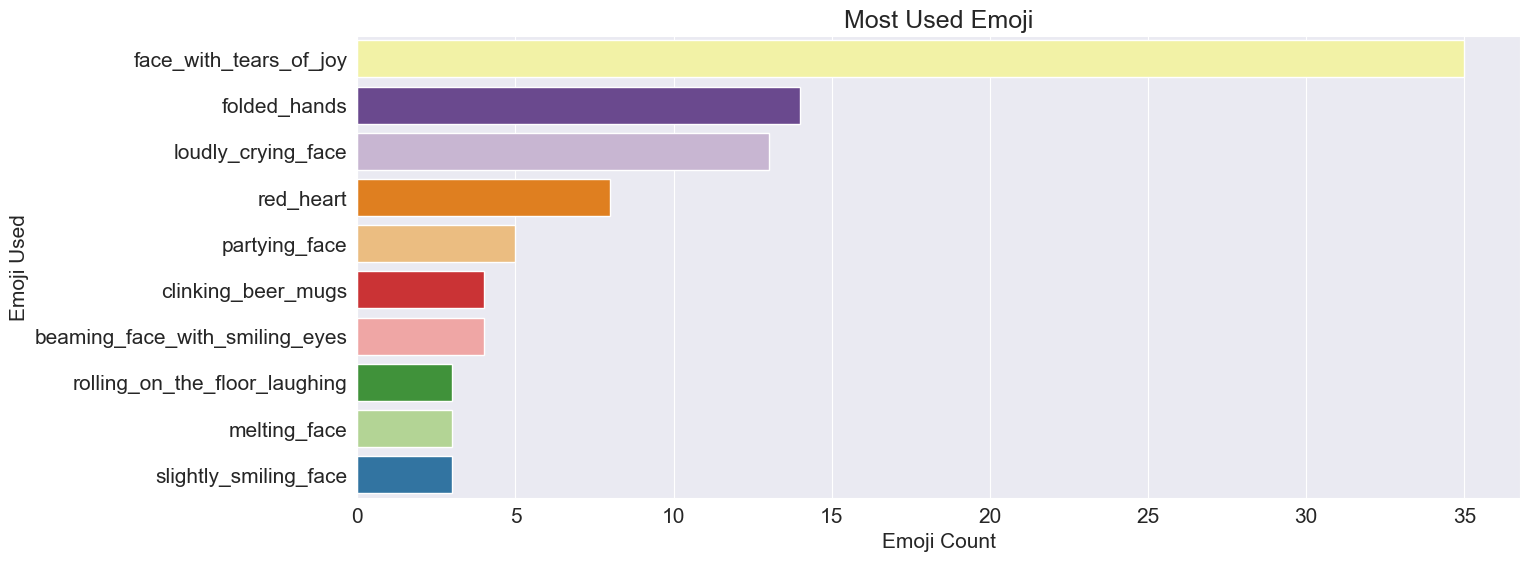

In [87]:
# Increasing the figure size
plt.figure(figsize=(15, 6))

# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 15

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting
sns.barplot(x='emoji_count', y='emoji_description', data=top10emojis, palette="Paired_r")

plt.title('Most Used Emoji')
plt.xlabel('Emoji Count')
plt.ylabel('Emoji Used')

# Saving the plot
plt.savefig('top10emoji.svg', format='svg')


#### Not that it is worth anything, but "😂" beats everyone by a huge margin!

# 6. Most active days, most active hours, most active months.

### *Pre-processing*

In [88]:
import pandas as pd

# Assuming 'date_time' is already a datetime column, if not, convert it:
df['date_time'] = pd.to_datetime(df['date_time'])

# Create a copy of the DataFrame
df3 = df.copy()

# Add a helper column for message count (if not already added)
df3['message_count'] = 1

# Extract the hour from the datetime column
df3['hour'] = df3['date_time'].dt.hour

# Group by 'hour' and count the number of messages
grouped_by_time = df3.groupby('hour').count().reset_index()

# Optionally, sort by hour if needed
grouped_by_time = grouped_by_time.sort_values(by='hour')

# Print or visualize the grouped data
print(grouped_by_time)



    hour  date_time  user  message  day  month  year  date  message_count
0      0         53    53       53   53     53    53    53             53
1      1          9     9        9    9      9     9     9              9
2      2          2     2        2    2      2     2     2              2
3      7          2     2        2    2      2     2     2              2
4      8          2     2        2    2      2     2     2              2
5      9        118   118      118  118    118   118   118            118
6     10        110   110      110  110    110   110   110            110
7     11         36    36       36   36     36    36    36             36
8     12        106   106      106  106    106   106   106            106
9     13         35    35       35   35     35    35    35             35
10    14         46    46       46   46     46    46    46             46
11    15         35    35       35   35     35    35    35             35
12    16         86    86       86   8

### Which hour of the day are most messages exchanged?

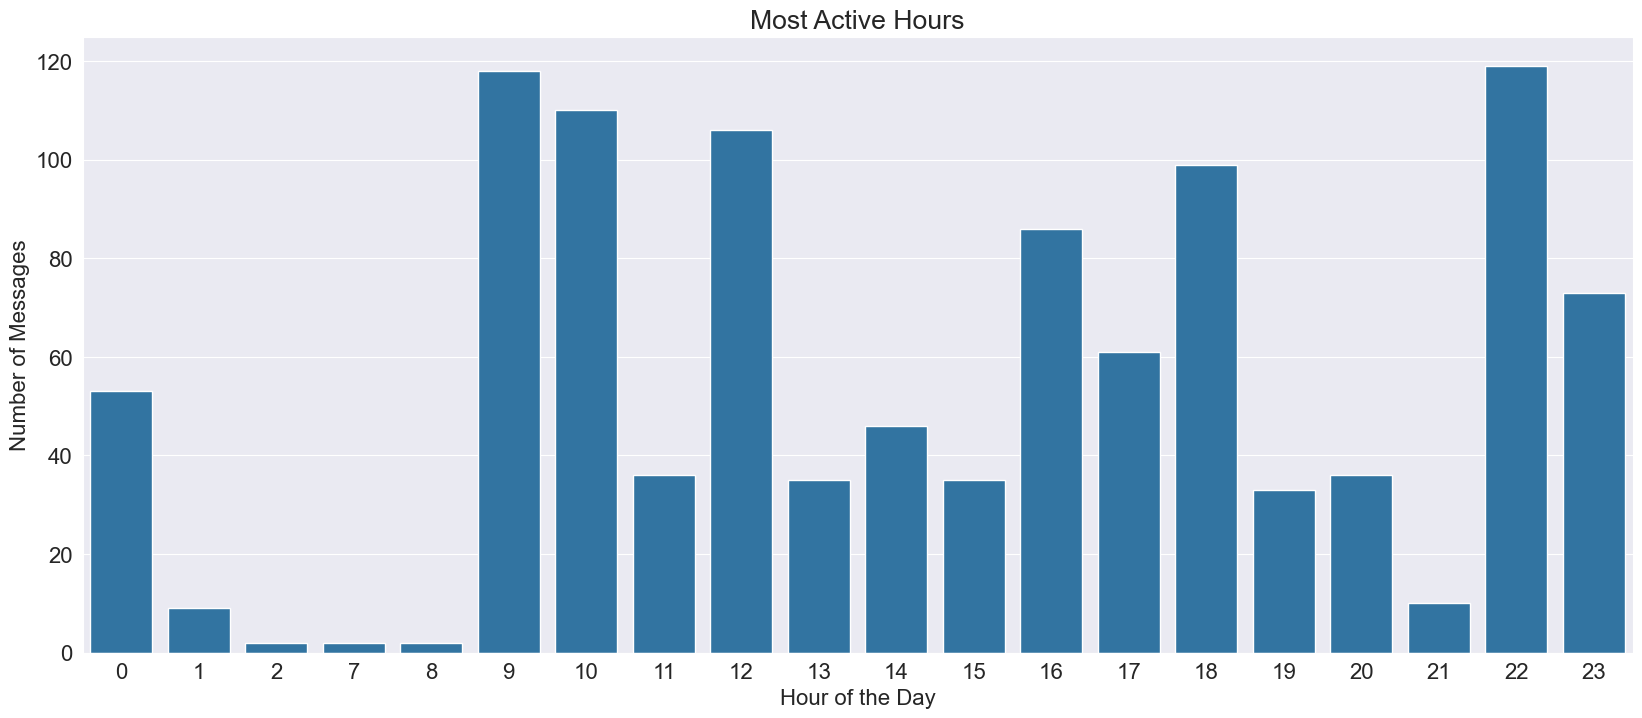

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (20, 8)

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# PLOT: grouped by hour
sns.barplot(x='hour', y='message_count', data=grouped_by_time)
plt.title('Most Active Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Messages');

# Saving the plot
plt.savefig('most_active_hours.svg', format='svg')


#### Intrestingly, the group is *most active around midnight*, followed by *afternoon*.

### *Pre-processing weekdays and months*

In [90]:
import pandas as pd

# Ensure 'date_time' column is properly converted to datetime type if not already
df3['date_time'] = pd.to_datetime(df3['date_time'])

# Create a new column for the day of the week (Monday, Tuesday, etc.)
df3['day_of_week'] = df3['date_time'].dt.day_name()

# Specify the desired order of days
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Group by day of the week and sum the message counts
grouped_by_day = df3.groupby('day_of_week')['message_count'].sum().reindex(days).fillna(0).reset_index()

# Rename columns for clarity
grouped_by_day.columns = ['day', 'message_count']

print(grouped_by_day)


# Create a new column for the month (January, February, etc.)
df3['month_name'] = df3['date_time'].dt.month_name()

# Specify the desired order of months
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September']

# Group by month and sum the message counts
grouped_by_month = df3.groupby('month_name')['message_count'].sum().reindex(months).fillna(0).reset_index()

# Rename columns for clarity
grouped_by_month.columns = ['month', 'message_count']

print(grouped_by_month)



         day  message_count
0     Monday            111
1    Tuesday            324
2  Wednesday            155
3   Thursday            171
4     Friday            148
5   Saturday             95
6     Sunday             67
       month  message_count
0    January          117.0
1   February          168.0
2      March          272.0
3      April           43.0
4        May           39.0
5       June          175.0
6       July           26.0
7     August            0.0
8  September           60.0


## *Visualization*
### Now, we will be plotting *grouped by day* and respective *group by month* simultaneously, to see some interesting results.
- Using `plt.subplots` to plot multiple charts in a grid.

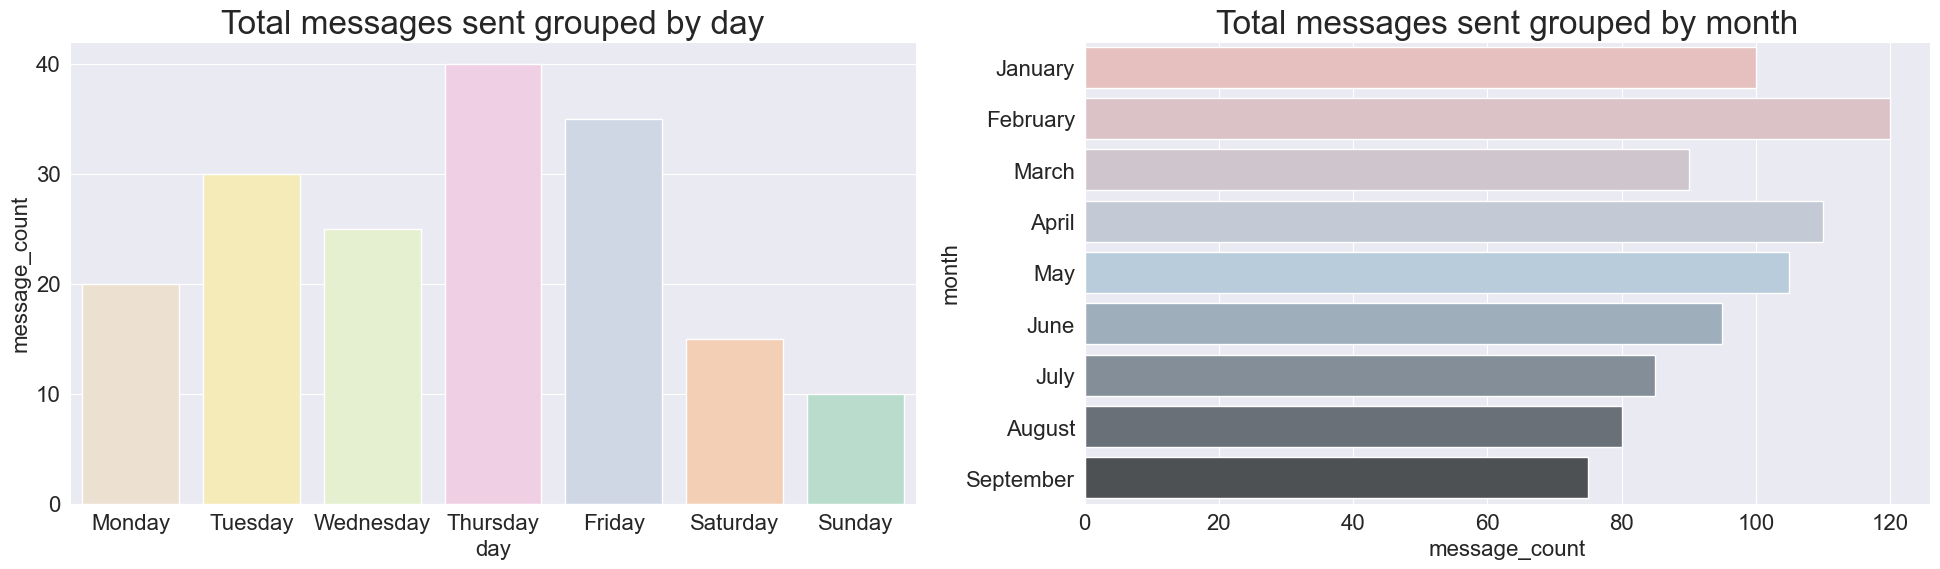

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a sample dataframe for illustration
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
grouped_by_day = pd.DataFrame({
    'day': days,
    'message_count': [20, 30, 25, 40, 35, 15, 10]  # Replace with your actual data
})

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September']
grouped_by_month = pd.DataFrame({
    'month': months,
    'message_count': [100, 120, 90, 110, 105, 95, 85, 80, 75]  # Replace with your actual data
})

fig, axs = plt.subplots(1, 2, figsize=(24, 6))

# Better Readability
import matplotlib
matplotlib.rcParams['font.size'] = 20

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# PLOT 1: Messages grouped by weekday
sns.barplot(x='day', y='message_count', data=grouped_by_day, order=days, ax=axs[0], palette='Pastel2_r')
axs[0].set_title('Total messages sent grouped by day')

# PLOT 2: Messages grouped by months
sns.barplot(x='message_count', y='month', data=grouped_by_month, order=months, ax=axs[1], palette='Pastel1_d')
axs[1].set_title('Total messages sent grouped by month')

# Saving the plots
plt.savefig('days_and_month.svg', format='svg')



##### The group is most active on Sundays, and least active on Mondays (probably *Monday Blues*)
##### It has been recently very active, in September.

### Now, we will plot a *heatmap*, combining the above to bar plots, for a better understanding! 

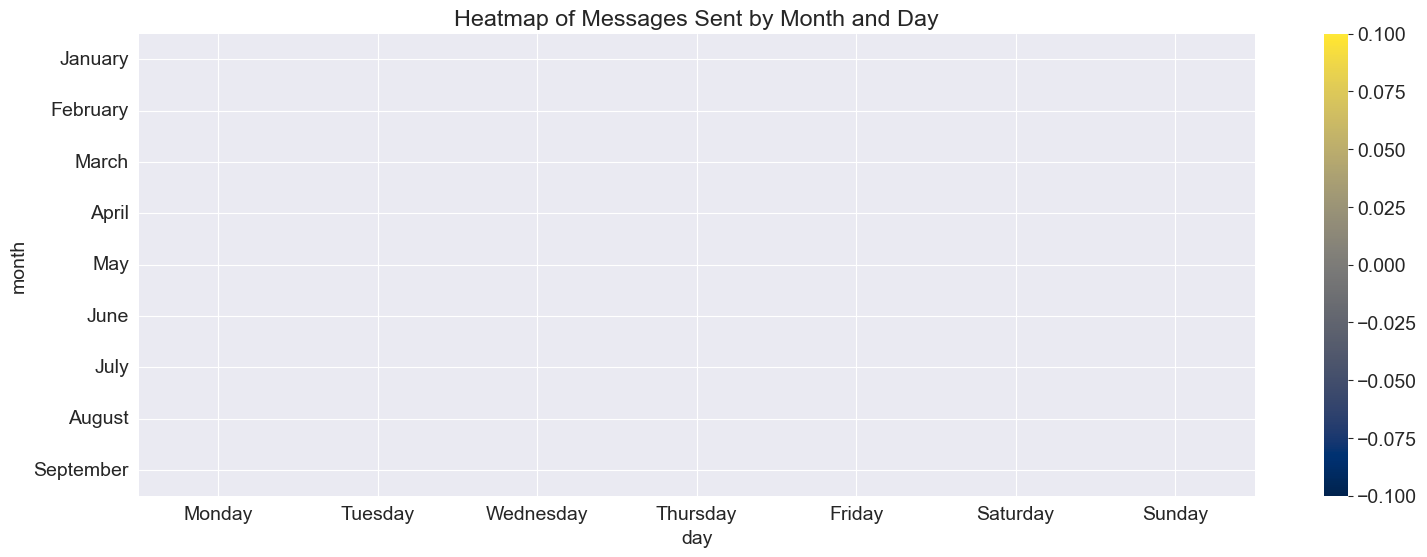

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Better Readability
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (18, 6)

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Ensure message_count is numeric (convert if needed)
df3['message_count'] = pd.to_numeric(df3['message_count'])

# Grouping by month and day, summing message_count
grouped_by_month_and_day = df3.groupby(['month', 'day'], as_index=False)['message_count'].sum()

# Specify the order of months and days
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September']
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a pivot table
pt = grouped_by_month_and_day.pivot(index='month', columns='day', values='message_count').reindex(index=months, columns=days)

# PLOT: heatmap
sns.heatmap(pt, cmap='cividis')
plt.title('Heatmap of Messages Sent by Month and Day')

# Saving the plot
plt.savefig('month_day_heatmap.svg', format='svg')

plt.show()


# *Inferences*
- The group is more active on weekends, throughout the months.
- September has the most lighter blue shades and more yellow gradients.
- This gives a combined analysis, which is really helpful in real-time projects.

# Most used words in the chat.
### Finally, I will be ending with *the most used words*, using `WordCloud` module in Python.

In [93]:
comment_words = ' '

# stopwords --> Words to be avoided while forming the WordCloud,
# removed group_notifications like 'joined', 'deleted';
# removed really common words like "yeah" and "okay".
stopwords = STOPWORDS.update(['group', 'link', 'invite', 'joined', 'message', 'deleted', 'yeah', 'hai', 'yes', 'okay', 'ok', 'will', 'use', 'using', 'one', 'know', 'guy', 'group', 'media', 'omitted'])


# iterate through the DataFrame.
for val in df3.message.values:
    
    # typecaste each val to string.
    val = str(val) 
    
    # split the value.
    tokens = val.split() 
    
    # Converts each token into lowercase.
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 8).generate(comment_words) 

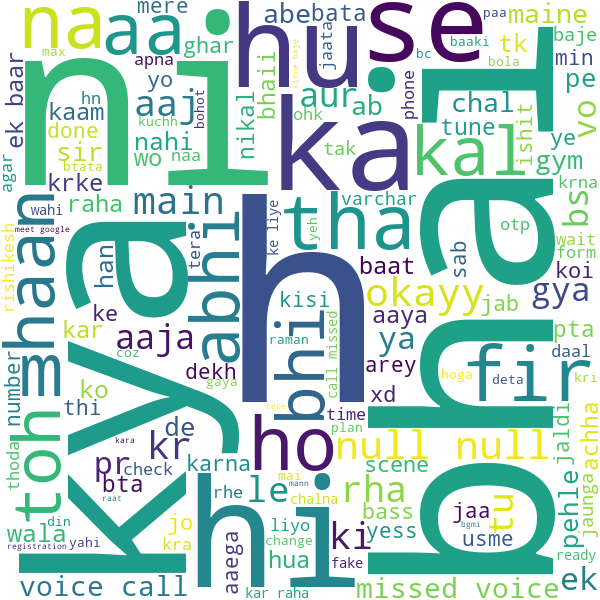

In [94]:
wordcloud.to_image()